In [1]:
import string
import os
import regex as re
import numpy as np
from itertools import combinations, chain
import pickle
from datetime import datetime

from lxml import etree
from operator import itemgetter

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import SnowballStemmer
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag, FreqDist

from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV, SelectFromModel
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

from scipy.sparse import vstack, hstack, coo_matrix
import matplotlib.pyplot as plt

from empath import Empath
from textblob import TextBlob

C:\Users\Denis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Pickle up all data:

In [2]:
'''X_times_train = pickle.load(open("./dumps/X_times_train.p", "rb" ))
X_sentence_len_train = pickle.load(open("./dumps/X_sentence_len_train.p", "rb" ))
X_post_cnt_train = pickle.load(open("./dumps/X_post_cnt_train.p", "rb" ))
X_sentiment_train = pickle.load(open("./dumps/X_sentiment_train.p", "rb" ))
X_subjectivity_train = pickle.load(open("./dumps/X_subjectivity_train.p", "rb" ))

X_times_test = pickle.load(open("./dumps/X_times_test.p", "rb" ))
X_sentence_len_test = pickle.load(open("./dumps/X_sentence_len_test.p", "rb" ))
X_post_cnt_test = pickle.load(open("./dumps/X_post_cnt_test.p", "rb" ))
X_sentiment_test = pickle.load(open("./dumps/X_sentiment_test.p", "rb" ))
X_subjectivity_test = pickle.load(open("./dumps/X_subjectivity_test.p", "rb" ))

X_pos_tags_train = pickle.load(open( "X_pos_tags_train.p", "rb" ))
X_pos_tags_test = pickle.load(open( "X_pos_tags_test.p", "rb" ))

X_lexicon_sizes_train = pickle.load(open( "X_lexicon_sizes_train.p", "rb" ))
X_lexicon_sizes_test = pickle.load(open( "X_lexicon_sizes_test.p", "rb" ))'''

'X_times_train = pickle.load(open("./dumps/X_times_train.p", "rb" ))\nX_sentence_len_train = pickle.load(open("./dumps/X_sentence_len_train.p", "rb" ))\nX_post_cnt_train = pickle.load(open("./dumps/X_post_cnt_train.p", "rb" ))\nX_sentiment_train = pickle.load(open("./dumps/X_sentiment_train.p", "rb" ))\nX_subjectivity_train = pickle.load(open("./dumps/X_subjectivity_train.p", "rb" ))\n\nX_times_test = pickle.load(open("./dumps/X_times_test.p", "rb" ))\nX_sentence_len_test = pickle.load(open("./dumps/X_sentence_len_test.p", "rb" ))\nX_post_cnt_test = pickle.load(open("./dumps/X_post_cnt_test.p", "rb" ))\nX_sentiment_test = pickle.load(open("./dumps/X_sentiment_test.p", "rb" ))\nX_subjectivity_test = pickle.load(open("./dumps/X_subjectivity_test.p", "rb" ))\n\nX_pos_tags_train = pickle.load(open( "X_pos_tags_train.p", "rb" ))\nX_pos_tags_test = pickle.load(open( "X_pos_tags_test.p", "rb" ))\n\nX_lexicon_sizes_train = pickle.load(open( "X_lexicon_sizes_train.p", "rb" ))\nX_lexicon_sizes_t

Class for Corpus preprocessing:

In [3]:
sw_diff = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'he', 'him', 'his', 'himself', 
           'she', 'her', 'hers', 'herself', 'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 
           'themselves', 'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
           'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 'totally', 'whole',
           'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.stopwords.difference_update(sw_diff)
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer(language='english')

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X, method='lem'):
        return [
            list(self.tokenize(doc, method)) if doc else [] for doc in X
        ]   

    def tokenize(self, document, method='lem'):
        if(method == 'lem'):
            # Break the document into sentences
            for sent in sent_tokenize(document):
                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):
                    # Apply preprocessing to the token
                    token = self.process_token(token)
                    if not self.is_valid_token(token):
                        continue
                        
                    # Lemmatize the token and yield
                    lemma = self.lemmatize(token, tag)
                    yield lemma
                    
        elif(method == 'stem'):
            # Break the document into tokens
            for token in wordpunct_tokenize(document):
                # Apply preprocessing to the token
                token = self.process_token(token)
                if not self.is_valid_token(token):
                    continue
                
                stem = self.stem(token)
                yield stem
        else:
            raise ValueError('Unknown method type.')

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
    
    def stem(self, token):
        return self.stemmer.stem(token)
    
    def process_token(self, token):
        token = token.lower() if self.lower else token
        token = token.strip() if self.strip else tcharoken
        token = token.strip('_') if self.strip else token
        token = token.strip('*') if self.strip else token
        return token
    
    def is_valid_token(self, token):
        # If stopword, token is invalid
        if token in self.stopwords:
            return False

        # If punctuation, token is invalid
        if all(char in self.punct for char in token):
            return False
        
        return True

This part of code loads data corpus from multiple files into lists X (texts) and y(labels) with one entry per user:

In [4]:
def read_entries(X_posts, X_titles, y, path_list, label_dict=None, user_ids=None, default_label=0):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
    
    IMAGE_STR = 'data:image'
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
        
            user_posts = []
            for post in root.findall('.//TEXT'):
                post = post.text.strip()
                if post != '':
                    if IMAGE_STR in post:
                        continue
                    post = re.sub(r"http\S+", " ", post)
                    post = re.sub(r"\d+", " ", post)
                    post = re.sub(u"\xa0", " ", post)
                    post = re.sub(u"\\p{P}+", " ", post)
                    user_posts.append(post.lower())
                else:
                    user_posts.append(None)
            
            user_titles = []
            for title in root.findall('.//TITLE'):
                title = title.text.strip()
                if title != '':
                    if IMAGE_STR in title:
                        continue
                    title = re.sub(r"http\S+", " ", title)
                    title = re.sub(r"\d+", " ", title)
                    title = re.sub(u"\xa0", " ", title)
                    title = re.sub(u"\\p{P}+", " ", title)
                    user_titles.append(title.lower())
                else:
                    user_titles.append(None)
            
            X_titles.append(user_titles)
            X_posts.append(user_posts)
            label = int(label_dict[user_id]) if label_dict else default_label
            y.append(label)
            if user_ids != None:
                user_ids.append(user_id)

In [5]:
def read_entries2(X, y, path_list, label_dict=None, default_label=0):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
    
    IMAGE_STR = 'data:image'
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
        
            user_text = ''
            for post in root.findall('.//TITLE') + root.findall('.//TEXT'):
                post = post.text.strip().strip()
                if post != '':
                    if IMAGE_STR in post:
                        continue
                    post = re.sub(r"http\S+", " ", post)
                    post = re.sub(r"\d+", " ", post)
                    post = re.sub(u"\xa0", " ", post)
                    post = re.sub(u"\\p{P}+", " ", post)
                    user_text += ' ' + post.lower()
            
            X.append(user_text)
            label = int(label_dict[user_id]) if label_dict else default_label
            y.append(label)

Utility methods for extracting features:

In [6]:
def get_avg_sentence_length(sentences):
    sum = 0
    for sentence in sentences:
        sentence = sentence.replace(' ', '')
        sum += len(sentence)
    return sum / len(sentences) if sentences else 0

In [7]:
def get_sentiment_and_subjectivity(sentences):
    sum_sentiment = 0
    sum_subjectivity = 0
    if len(sentences) > 0:
        for sentence in sentences:
            tb = TextBlob(sentence)
            sum_sentiment += tb.sentiment.polarity
            sum_subjectivity += tb.sentiment.subjectivity
        sum_sentiment = sum_sentiment / float(len(sentences))
        sum_subjectivity = sum_subjectivity / float(len(sentences))
        return (sum_sentiment, sum_subjectivity)
    else:
        return (0.0, 0.0)
        

In [8]:
def read_features(X_times, X_sentence_lengths, X_post_cnt, X_sentiment,
                  X_subjectivity, X_post_lengths, X_post_freq, path_list):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
        
    IMAGE_STR = 'data:image'
    datetime_pattern = '%Y-%m-%d %H:%M:%S'
    date_end = None
    date_start = None
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
            
            sentences = []
            post_lengths = []
            post_cnt = 0
            for post in root.findall('.//TEXT'):
                post_cnt += 1
                post = post.text.strip()
                if post != '':
                    sentences.extend(sent_tokenize(post))
                    post_lengths.append(len(post))
                else:
                    post_lengths.append(0)
            
            avg_sentiment, avg_subjectivity = get_sentiment_and_subjectivity(sentences)
            avg_sentence_length = get_avg_sentence_length(sentences)
            avg_post_length = np.mean(post_lengths)
            
            sum_hours = 0
            for date in root.findall('.//DATE'):
                date = date.text.strip()
                if date != '':                    
                    if not date_end:
                        date_end = datetime.strptime(date, datetime_pattern)
                    date_start = datetime.strptime(date, datetime_pattern)
                    
                    m = re.match(r'\d{4}-\d{2}-\d{2} (\d{2}).*', date)
                    hour = int(m.group(1))
                    sum_hours += hour
            
            post_span_minutes = (date_end - date_start).total_seconds()/60
            post_freq = post_span_minutes / post_cnt
            
            time = [0] * 8
            avg_hour = sum_hours / post_cnt
            index = int(avg_hour // 3)
            time[index] = 1
            
            X_post_cnt.append([post_cnt])
            X_sentence_lengths.append([avg_sentence_length])
            X_times.append(time)
            X_sentiment.append([avg_sentiment])
            X_subjectivity.append([avg_subjectivity])
            X_post_lengths.append([avg_post_length])
            X_post_freq.append([post_freq])

Reading input files:

In [9]:
cwd = os.getcwd()
TRAIN_PATH = os.path.join(cwd, "reddit-training-ready-to-share")
TEST_PATH = os.path.join(cwd, "reddit-test-data-ready-to-share")

TRAIN_POSITIVE_PATH = os.path.join(TRAIN_PATH, "positive_examples_anonymous")
TRAIN_NEGATIVE_PATH = os.path.join(TRAIN_PATH, "negative_examples_anonymous")

TEST_POSITIVE_PATH = os.path.join(TEST_PATH, "positive_examples_anonymous")
TEST_NEGATIVE_PATH = os.path.join(TEST_PATH, "negative_examples_anonymous")

TRAIN_LABELS_PATH = os.path.join(cwd, 'risk_golden_truth.txt')

IMAGE_STR = 'data:image'

train_labels_file = open(TRAIN_LABELS_PATH, 'r')
train_label_dict = {}
for line in train_labels_file:
    xml_file, label = line.split(' ')
    train_label_dict[xml_file] = label
train_labels_file.close()

In [10]:
X_train_raw_posts_lists = []
X_train_raw_titles_lists = []
y_train = []
X_test_raw_posts_lists = []
X_test_raw_titles_lists = []
y_test = []

user_ids_test = []

X_train_raw = []
X_test_raw = []

train_entry_path_list = [TRAIN_POSITIVE_PATH, TRAIN_NEGATIVE_PATH]
test_pos_entry_path_list = [TEST_POSITIVE_PATH]
test_neg_entry_path_list = [TEST_NEGATIVE_PATH]

read_entries(X_posts=X_train_raw_posts_lists, X_titles=X_train_raw_titles_lists,
             y=y_train, path_list=train_entry_path_list, label_dict=train_label_dict)
read_entries(X_posts=X_test_raw_posts_lists, X_titles=X_test_raw_titles_lists,
             y=y_test, path_list=test_pos_entry_path_list, user_ids=user_ids_test, default_label=1)
read_entries(X_posts=X_test_raw_posts_lists, X_titles=X_test_raw_titles_lists,
             y=y_test, path_list=test_neg_entry_path_list, user_ids=user_ids_test, default_label=0)

In [11]:
def get_concat_posts_set(X_posts, X_titles, num_of_posts=None):
    X_new = []
    take = None
    
    for user_i in range(len(X_posts)):
        user_posts = X_posts[user_i]
        user_titles = X_titles[user_i]
        
        if not num_of_posts:
            take = len(user_posts)
        else:
            take = min(num_of_posts, len(user_posts))
        
        user_text = ''
        for i in range(take):
            if user_titles[i]:
                user_text += ' ' + user_titles[i]
            if user_posts[i]:
                user_text += ' ' + user_posts[i]
        X_new.append(user_text)
    return X_new

In [12]:
X_train_raw = get_concat_posts_set(X_train_raw_posts_lists, X_train_raw_titles_lists)
X_test_raw = get_concat_posts_set(X_test_raw_posts_lists, X_test_raw_titles_lists)

In [13]:
def get_pronoun_and_absolutizm_features(X_prep):
    
    fp_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    
    tp_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                   'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    absolutisms = {'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
                   'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                   'totally', 'whole', 'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}


    fp_freq = []
    tp_freq = []
    absolutisms_freq = []
    
    for entry in X_prep:
        sum_fp = 0
        sum_tp = 0
        sum_abs = 0
        for word in entry:
            if word in fp_pronouns:
                sum_fp += 1
            elif word in tp_pronouns:
                sum_tp += 1
            elif word in absolutisms:
                sum_abs += 1
        sum_fp = sum_fp / float(len(entry))
        sum_tp = sum_tp / float(len(entry))
        sum_abs = sum_abs / float(len(entry))
        fp_freq.append([sum_fp])
        tp_freq.append([sum_tp])
        absolutisms_freq.append([sum_abs])
    
    return (fp_freq, tp_freq, absolutisms_freq)        

In [14]:
def get_pronoun_and_absolutizm_features2(X_raw):
    
    fp_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    
    tp_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                   'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    absolutisms = {'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
                   'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                   'totally', 'whole', 'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}


    fp_freq = []
    tp_freq = []
    absolutisms_freq = []
    
    for entry in X_raw:
        sum_fp = 0
        sum_tp = 0
        sum_abs = 0
        tokens = word_tokenize(entry)
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if not word.isnumeric()]
        fdist = FreqDist(tokens)
        w, f = fdist.most_common(1)[0]
        for word in tokens:
            if word in fp_pronouns:
                sum_fp += 1
            elif word in tp_pronouns:
                sum_tp += 1
            elif word in absolutisms:
                sum_abs += 1
        sum_fp = sum_fp / float(f)
        sum_tp = sum_tp / float(f)
        sum_abs = sum_abs / float(f)
        fp_freq.append([sum_fp])
        tp_freq.append([sum_tp])
        absolutisms_freq.append([sum_abs])
    
    return (fp_freq, tp_freq, absolutisms_freq)        

Extracting features:

In [ ]:
X_times_train = []
X_times_test = []

X_sentence_len_train = []
X_sentence_len_test = []

X_post_cnt_train = []
X_post_cnt_test = []

X_sentiment_train = []
X_sentiment_test = []

X_subjectivity_train = []
X_subjectivity_test = []

X_post_lengths_train = []
X_post_lengths_test = []

X_post_freq_train = []
X_post_freq_test = []

read_features(X_times=X_times_train, X_sentence_lengths=X_sentence_len_train, X_post_cnt=X_post_cnt_train,
              X_sentiment=X_sentiment_train, X_subjectivity=X_subjectivity_train, X_post_lengths=X_post_lengths_train,
              X_post_freq=X_post_freq_train, path_list=train_entry_path_list)
read_features(X_times=X_times_test, X_sentence_lengths=X_sentence_len_test, X_post_cnt=X_post_cnt_test,
              X_sentiment=X_sentiment_test, X_subjectivity=X_subjectivity_test, X_post_lengths=X_post_lengths_test,
              X_post_freq=X_post_freq_test, path_list=test_pos_entry_path_list)
read_features(X_times=X_times_test, X_sentence_lengths=X_sentence_len_test, X_post_cnt=X_post_cnt_test,
              X_sentiment=X_sentiment_test, X_subjectivity=X_subjectivity_test, X_post_lengths=X_post_lengths_test,
              X_post_freq=X_post_freq_test, path_list=test_neg_entry_path_list)

In [ ]:
X_fp_pronouns_train, X_tp_pronouns_train, X_absolutisms_train = get_pronoun_and_absolutizm_features2(X_train_raw)
X_fp_pronouns_test, X_tp_pronouns_test, X_absolutisms_test = get_pronoun_and_absolutizm_features2(X_test_raw)

In [ ]:
def get_semantic_features(X):
    lexicon = Empath()
    
    relevant_lexical_categories = ['negative_emotion', 'positive_emotion', 'communication',
                                    'violence', 'business', 'nervousness', 'body', 'pain',
                                    'internet', 'work', 'shame', 'poor'
                              ]
    
    relevant_lexical_categories2 = ['negative_emotion', 'positive_emotion',
                                   'nervousness', 'love', 'shame', 'pain'
                              ]
    
    relevant_lexical_categories3 = ['friends', 'positive_emotion', 'negative_emotion', 
                                   'nervousness', 'love', 'shame', 'pain', 'optimism', 'sadness',
                                    'speaking'
                              ]

    relevant_lexical_categories4 = ['positive_emotion', 'negative_emotion']
    
    feature_mat = []
    for text in X:
        d = lexicon.analyze(text, categories=relevant_lexical_categories4, normalize=True)
        if (not d):
            feature_mat.append([0] * len(relevant_lexical_categories4))
        else:
            feature_mat.append([d[key] for key in sorted(d.keys(), reverse=False)])
    return feature_mat

In [ ]:
X_sem_feat_train = get_semantic_features(X_train_raw)
X_sem_feat_test = get_semantic_features(X_test_raw)

In [19]:
pickle.dump(X_times_train, open("./dumps/X_times_train.p", "wb" ))
pickle.dump(X_sentence_len_train, open("./dumps/X_sentence_len_train.p", "wb" ))
pickle.dump(X_post_cnt_train, open("./dumps/X_post_cnt_train.p", "wb" ))
pickle.dump(X_sentiment_train, open("./dumps/X_sentiment_train.p", "wb" ))
pickle.dump(X_subjectivity_train, open("./dumps/X_subjectivity_train.p", "wb" ))
pickle.dump(X_post_lengths_train, open("./dumps/X_post_lengths_train.p", "wb" ))
pickle.dump(X_post_freq_train, open("./dumps/X_post_freq_train.p", "wb" ))
pickle.dump(X_fp_pronouns_train, open("./dumps/X_fp_pronouns_train.p", "wb" ))
pickle.dump(X_tp_pronouns_train, open("./dumps/X_tp_pronouns_train.p", "wb" ))
pickle.dump(X_absolutisms_train, open("./dumps/X_absolutisms_train.p", "wb" ))

pickle.dump(X_times_test, open("./dumps/X_times_test.p", "wb" ))
pickle.dump(X_sentence_len_test, open("./dumps/X_sentence_len_test.p", "wb" ))
pickle.dump(X_post_cnt_test, open("./dumps/X_post_cnt_test.p", "wb" ))
pickle.dump(X_sentiment_test, open("./dumps/X_sentiment_test.p", "wb" ))
pickle.dump(X_subjectivity_test, open("./dumps/X_subjectivity_test.p", "wb" ))
pickle.dump(X_post_lengths_test, open("./dumps/X_post_lengths_test.p", "wb" ))
pickle.dump(X_post_freq_test, open("./dumps/X_post_freq_test.p", "wb" ))
pickle.dump(X_fp_pronouns_test, open("./dumps/X_fp_pronouns_test.p", "wb" ))
pickle.dump(X_tp_pronouns_test, open("./dumps/X_tp_pronouns_test.p", "wb" ))
pickle.dump(X_absolutisms_test, open("./dumps/X_absolutisms_test.p", "wb" ))

pickle.dump(X_sem_feat_train, open("./dumps/X_sem_feat_train.p", "wb" ))
pickle.dump(X_sem_feat_test, open("./dumps/X_sem_feat_test.p", "wb" ))

We use X list as input to NLTKPreprocessor class which outputs list of preprocessed, tokenized texts:

In [ ]:
preprocessor = NLTKPreprocessor()
preprocess_method = 'stem'
X_train_prep = preprocessor.transform(X_train_raw, method=preprocess_method)
X_test_prep = preprocessor.transform(X_test_raw, method=preprocess_method)

X_train_prep_posts_lists = []
X_train_prep_titles_lists = []

X_test_prep_posts_lists = []
X_test_prep_titles_lists = []

for user in X_train_raw_posts_lists:
    X_train_prep_posts_lists.append(preprocessor.transform(user, method=preprocess_method))
for user in X_train_raw_titles_lists:
    X_train_prep_titles_lists.append(preprocessor.transform(user, method=preprocess_method)) 

for user in X_test_raw_posts_lists:
    X_test_prep_posts_lists.append(preprocessor.transform(user, method=preprocess_method))
for user in X_test_raw_titles_lists:
    X_test_prep_titles_lists.append(preprocessor.transform(user, method=preprocess_method))

In [ ]:
def get_pos_tags(X):
    pos_tag_mat = []
    for tokens in X:
       # tag_dict = { 'CC': 0, 'DT': 0, 'IN': 0, 'JJ': 0, 'JJR': 0, 'JJS': 0,
       #             'NN': 0, 'NNP':0, 'NNS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0,
       #             'RBR': 0, 'RBS': 0, 'RP': 0, 'VB': 0, 'VBD': 0, 'VBG': 0,
        #            'VBN': 0, 'VBP': 0, 'VBZ': 0}
        tag_dict = {'JJ': 0, 'JJS': 0,
                    'NN': 0, 'NNS': 0, 'PRP': 0, 'PRP$': 0,
                    'RBS': 0, 'VB': 0, 'VBD': 0,
                    'VBN': 0, 'VBP': 0, 'VBZ': 0}
        
        text_len = len(tokens)
        tags = pos_tag(tokens)
        
        for word, tag in tags:
            if tag in tag_dict.keys():
                tag_dict[tag] += 1/text_len
        
        tag_freq = [tag_dict[key] for key in sorted(tag_dict.keys(), reverse=False)]
        pos_tag_mat.append(tag_freq)
    
    return pos_tag_mat

In [ ]:
X_pos_tags_train = get_pos_tags(X_train_prep)
X_pos_tags_test = get_pos_tags(X_test_prep)

In [23]:
pickle.dump(X_pos_tags_train, open("./dumps/X_pos_tags_train.p", "wb" ))
pickle.dump(X_pos_tags_test, open("./dumps/X_pos_tags_test.p", "wb" ))

In [ ]:
def get_lexicon_sizes(X):
    unique_cnt_mat = []
    for tokens in X:
        unique_cnt_mat.append([len(set(tokens))])
    
    return unique_cnt_mat

In [ ]:
X_lexicon_sizes_train = get_lexicon_sizes(X_train_prep)
X_lexicon_sizes_test = get_lexicon_sizes(X_test_prep)

In [26]:
pickle.dump(X_lexicon_sizes_train, open("./dumps/X_lexicon_sizes_train.p", "wb" ))
pickle.dump(X_lexicon_sizes_test, open("./dumps/X_lexicon_sizes_test.p", "wb" ))

We use tf-idf vectorizer for vector representation of the documents:

In [ ]:
def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

In [ ]:
vect = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, ngram_range=(1, 1), min_df=30)
X_train = vect.fit_transform(X_train_prep, y_train)
X_test = vect.transform(X_test_prep)

In [29]:
#print(vect.get_feature_names())
#print(X_train.getnnz())

Normalizing and adding features:

In [ ]:
max_abs_scaler = StandardScaler()
#max_abs_scaler = MaxAbsScaler()
#max_abs_scaler = MinMaxScaler()
X_sentence_len_train_scaled = max_abs_scaler.fit_transform(X_sentence_len_train)
X_sentence_len_test_scaled = max_abs_scaler.transform(X_sentence_len_test)

X_sem_feat_train_scaled = max_abs_scaler.fit_transform(X_sem_feat_train)
X_sem_feat_test_scaled = max_abs_scaler.transform(X_sem_feat_test)

X_post_cnt_train_scaled = max_abs_scaler.fit_transform(X_post_cnt_train)
X_post_cnt_test_scaled = max_abs_scaler.transform(X_post_cnt_test)

X_sentiment_train_scaled = max_abs_scaler.fit_transform(X_sentiment_train)
X_sentiment_test_scaled = max_abs_scaler.transform(X_sentiment_test)

X_subjectivity_train_scaled = max_abs_scaler.fit_transform(X_subjectivity_train)
X_subjectivity_test_scaled = max_abs_scaler.transform(X_subjectivity_test)

X_fp_pronouns_train_scaled = max_abs_scaler.fit_transform(X_fp_pronouns_train)
X_fp_pronouns_test_scaled = max_abs_scaler.transform(X_fp_pronouns_test)

X_tp_pronouns_train_scaled = max_abs_scaler.fit_transform(X_tp_pronouns_train)
X_tp_pronouns_test_scaled = max_abs_scaler.transform(X_tp_pronouns_test)

X_absolutisms_train_scaled = max_abs_scaler.fit_transform(X_absolutisms_train)
X_absolutisms_test_scaled = max_abs_scaler.transform(X_absolutisms_test)

X_pos_tags_train_scaled = max_abs_scaler.fit_transform(X_pos_tags_train)
X_pos_tags_test_scaled = max_abs_scaler.transform(X_pos_tags_test)

X_lexicon_sizes_train_scaled = max_abs_scaler.fit_transform(X_lexicon_sizes_train)
X_lexicon_sizes_test_scaled = max_abs_scaler.transform(X_lexicon_sizes_test)

X_post_lengths_train_scaled = max_abs_scaler.fit_transform(X_post_lengths_train)
X_post_lengths_test_scaled = max_abs_scaler.transform(X_post_lengths_test)

X_post_freq_train_scaled = max_abs_scaler.fit_transform(X_post_freq_train)
X_post_freq_test_scaled = max_abs_scaler.transform(X_post_freq_test)

Building and evaluating models:

In [ ]:
#helper function to find allsubsets of a set (needed to find all subsets of set of new feature for CV)
allsubsets = lambda n: list(chain(*[combinations(range(n), ni) for ni in range(n+1)]))

# r - return only subsets of r size (reduction of search space) + empty set; if None, return all subsets
def get_subsets(n, r=None):
    if r==None:
        return allsubsets(n)
    else:
        combs = list(combinations(range(n), r))
        return combs

In [ ]:
def majority_weight(w):
    return 1.0 / (1.0 + w)

def minority_weight(w):
    return w / (1.0 + w)

In [ ]:
#Function for k-fold cross-validation of a model
#Performs grid search on C parameter, subsets of new features and k-best token features by chi2 stat
#For model_name parameter use 'SVM' - SVM or 'LR' - LogisticRegression

#EXAMPLE: see example below baseline for CV of SVM model
def cross_validate_model(model_name, X_train, y_train, C_list, k_list, new_features, k_folds, subset_size=None,
                        regularization='l2'):
    feature_subsets = get_subsets(len(new_features), subset_size)
    best_C = 0
    best_k = 0
    best_feature_set = {}
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])
    
    for k_features in k_list:
        
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        
        for c in C_list:
            
            if model_name == 'SVM':
                model = LinearSVC(class_weight='balanced', C=c, penalty=regularization) 
            elif model_name == 'LR':
                model = LogisticRegression(class_weight='balanced', C=c, penalty=regularization)
            
            for subset in feature_subsets:
                X_new = X_kbest_train
                for i in subset:
                    X_new = hstack([X_new, new_features[i]])
                scores = cross_val_score(model, X_new, y_train, cv=k_folds, scoring=scorer)
                mean = scores.mean()
                if mean > best_score:
                    best_score = mean
                    best_C = c
                    best_k = k_features
                    best_feature_set = subset
         
    return (best_score, best_k, best_C, best_feature_set)

In [35]:
def feature_cross_validate_model(model_name, X_train, y_train, C_list, k_list, k_folds, feature, regularization='l2'):
    best_C = 0
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])    
    best_k = 0
    
    for k_features in k_list:
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        X_kbest_train = hstack([X_kbest_train, feature])

        for c in C_list:
                if model_name == 'SVM':
                    model = LinearSVC(class_weight='balanced', C=c, penalty=regularization) 
                elif model_name == 'LR':
                    model = LogisticRegression(class_weight='balanced', C=c, penalty=regularization)

                scores = cross_val_score(model, X_kbest_train, y_train, cv=k_folds, scoring=scorer)
                mean = scores.mean()
                if mean > best_score:
                        best_score = mean
                        best_C = c
                        best_k = k_features

    return (best_score, best_C, best_k)

In [36]:
def cross_validate_baseline(model_name, X_train, y_train, C_list, k_list, k_folds, regularization='l2'):
    best_C = 0
    best_score = -1
    best_k = 0
    scorer = make_scorer(f1_score, average='macro', labels=[1])
    
    for k_features in k_list:
        
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        
        for c in C_list:
            if model_name == 'SVM':
                model = LinearSVC(class_weight="balanced", C=c, penalty=regularization) 
            elif model_name == 'LR':
                model = LogisticRegression(class_weight="balanced", C=c, penalty=regularization)

            scores = cross_val_score(model, X_kbest_train, y_train, cv=k_folds, scoring=scorer)
            mean = scores.mean()
            if mean > best_score:
                    best_score = mean
                    best_C = c
                    best_k = k_features
         
    return (best_score, best_k, best_C)

In [37]:
def cross_validate_new_features(model_name, X_train, y_train, C_list, k_folds, regularization='l2'):
    best_C = 0
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])
        
    for c in C_list:
        if model_name == 'SVM':
            model = LinearSVC(class_weight="balanced", C=c, penalty=regularization) 
        elif model_name == 'LR':
            model = LogisticRegression(class_weight="balanced", C=c, penalty=regularization)

        scores = cross_val_score(model, X_train, y_train, cv=k_folds, scoring=scorer)
        mean = scores.mean()
        if mean > best_score:
                best_score = mean
                best_C = c
         
    return (best_score, best_C)

In [117]:
#CV for Logistic Regression Baseline
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_k, best_C = cross_validate_baseline('LR', X_train, y_train, C_range, k_range, 5, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6671353496353496
Best C: 16.0
Best k: 1500


In [119]:
#CV for SVM baseline
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_k, best_C = cross_validate_baseline('SVM', X_train, y_train, C_range, k_range, 5)

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6879221432162609
Best C: 8.0
Best k: 1500


In [38]:
print("Building for evaluation: BASELINE Logistic Regression L1")

model = LogisticRegression(class_weight='balanced', penalty='l1', C=16.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: BASELINE Logistic Regression L1
Classification Report:

             precision    recall  f1-score   support

          0     0.9517    0.8949    0.9224       352
          1     0.5067    0.7037    0.5891        54

avg / total     0.8925    0.8695    0.8781       406



In [ ]:
cv = StratifiedKFold(n_splits = 10, random_state = 1)
X_all = vstack([X_train, X_test])
y_all = y_train + y_test

In [ ]:
pipe_LR = Pipeline([('chi2_selector', SelectKBest(chi2, k=1500)), 
                    ('clf', LogisticRegression(class_weight='balanced', penalty='l1', C=16.0))])
f1_LR = cross_val_score(pipe_LR, X_all, y_all, scoring='f1', cv =10, n_jobs=-1, verbose = 10)


In [120]:
print("Building for evaluation: BASELINE SVM")

model = LinearSVC(class_weight='balanced', C=8.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: BASELINE SVM
Classification Report:

             precision    recall  f1-score   support

          0     0.9547    0.8977    0.9253       352
          1     0.5200    0.7222    0.6047        54

avg / total     0.8969    0.8744    0.8827       406



In [ ]:
cv = StratifiedKFold(n_splits = 10, random_state = 1)
pipe_SVM = Pipeline([('chi2_selector', SelectKBest(chi2, k=1500)), 
                    ('clf', LinearSVC(class_weight='balanced', C=8.0))])
f1_SVM = cross_val_score(pipe_SVM, X_all, y_all, scoring='f1', cv =cv, n_jobs=-1, verbose = 10, )

In [121]:
print("Voting classifier for baselines (SVM + LR)")

model1 = LogisticRegression(class_weight='balanced', C=16.0, penalty='l1')
model2 = SVC(class_weight='balanced', kernel='linear', C=8.0, probability=True)
model = VotingClassifier(estimators=[('lr', model1), ('svm', model2)], voting='soft')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)
model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Voting classifier for baselines (SVM + LR)
Classification Report:

             precision    recall  f1-score   support

          0     0.9452    0.9318    0.9385       352
          1     0.5932    0.6481    0.6195        54

avg / total     0.8984    0.8941    0.8961       406



/home/andrija/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [157]:
#Cross validation of SVM
C_range = 2. ** np.arange(-1, 9)
#k_range = np.arange(10, 3000, 300)
#C_range = [0.01, 0.1, 1, 10, 100]
k_range = [1500]
new_features = [X_times_train, X_sentence_len_train_scaled, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set = cross_validate_model('SVM', X_train, y_train, C_range,
                                                                   k_range, new_features, 4, 10)

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set))

Best score: 0.7338615522783135
Best C: 32.0
Best k: 1200
Best new feature subset: (0, 1, 2, 3, 4, 5, 6, 7, 9, 10)


In [321]:
final_training = [X_times_train, X_sentence_len_train_scaled, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

final_testing = [X_times_test, X_sentence_len_test_scaled, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_pos_tags_test_scaled, X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

reduced_training = [X_sentence_len_train_scaled, X_sem_feat_train_scaled[:,:3],
                      X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

reduced_testing = [X_sentence_len_test_scaled, X_sem_feat_test_scaled[:,:3],
                    X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

In [184]:
#malo igranje
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_C = cross_validate_new_features('LR', np.hstack(final_training), y_train, C_range, 5, regularization='l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))

Best score: 0.6091847684072148
Best C: 0.5


Optimal number of features : 10
[ True False  True  True False  True  True  True  True  True  True  True]


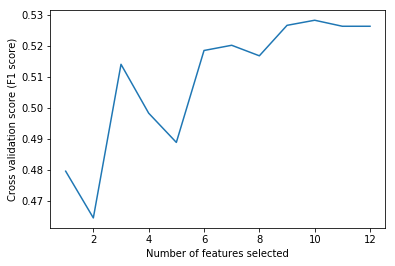

In [344]:
estimator = LogisticRegression(class_weight='balanced', C=1.0, penalty='l1')
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring=make_scorer(f1_score, average='macro', labels=[1]))
X_train_new = selector.fit_transform(np.hstack(reduced_training), y_train)
X_test_new = selector.transform(np.hstack(reduced_testing))
print("Optimal number of features : %d" % selector.n_features_)
print(selector.support_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1 score)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

Feature ranking:
1. feature 6 (0.140747)
2. feature 2 (0.096533)
3. feature 10 (0.092257)
4. feature 3 (0.091629)
5. feature 8 (0.089495)
6. feature 11 (0.081412)
7. feature 7 (0.075232)
8. feature 5 (0.073490)
9. feature 1 (0.072865)
10. feature 9 (0.065174)
11. feature 0 (0.063258)
12. feature 4 (0.057908)
(486, 5)


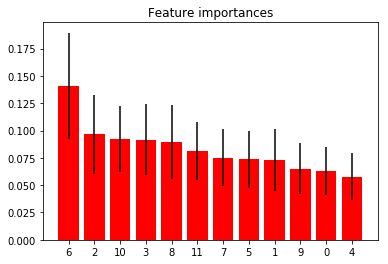

In [396]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500, random_state=0)
X = np.hstack(reduced_training)
forest.fit(X, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
selector = SelectFromModel(forest, prefit=True)
X_train_new = selector.transform(np.hstack(reduced_training))
X_test_new = selector.transform(np.hstack(reduced_testing))
print(X_train_new.shape)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [399]:
#Individual feature CV
#C_range = 2. ** np.arange(-1, 8)
C_range = [1, 2, 4, 8, 9, 10, 12, 14, 16, 18, 20, 21, 22, 23, 32, 64]
k_range = [1500]
best_score, best_C, best_k = feature_cross_validate_model('LR', X_train, y_train, C_range, k_range, 5, 
                                                  X_train_new, regularization='l1')
print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6635894660894661
Best C: 22
Best k: 1500


In [400]:
print("Building for evaluation: Logistic Regression classifier")

model = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = hstack([X_kbest_train, X_train_new])  
X_final_test = hstack([X_kbest_test, X_test_new])

#X_final_train = np.hstack(final_training)
#X_final_test = np.hstack(final_testing)

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: Logistic Regression classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9520    0.9006    0.9255       352
          1     0.5205    0.7037    0.5984        54

avg / total     0.8946    0.8744    0.8820       406



In [ ]:
X_final_all = vstack([X_train, X_test]).toarray()
print(X_final_all.shape)
X_final_new = vstack([X_train_new, X_test_new]).toarray()
print(X_final_new.shape)
y_all = y_train + y_test

In [ ]:
cv = StratifiedKFold(n_splits = 10, random_state = 1)
chi2_selector = SelectKBest(chi2, k=1500)
lr_model = LogisticRegression(class_weight='balanced', C=16.0, penalty='l1')
f1_lr_ours = []
for train_indices, test_indices in cv.split(X_final_all, y_all):
    X_train_cv = X_final_all[train_indices, :]
    y_train_cv = [y_all[i] for i in train_indices]
    X_train_new_cv = X_final_new[train_indices, :]
    X_train_kbest = chi2_selector.fit_transform(X_train_cv, y_train_cv) 
    X_train_all_kbest = np.hstack([X_train_kbest, X_train_new_cv])
    #for i in range(len(X_train_kbest)):
    #    X_train_all_kbest.append(X_train_kbest + X_train_new_cv)
    #print(len(X_train_all_kbest))
    lr_model.fit(X_train_all_kbest, y_train_cv)
    X_test_cv = X_final_all[test_indices, :]
    X_test_new_cv = X_final_new[test_indices, :]
    y_test_cv = [y_all[i] for i in test_indices]
    X_test_kbest = chi2_selector.transform(X_test_cv)
    X_test_all_kbest = np.hstack([X_test_kbest, X_test_new_cv])
    f1_lr_ours.append(f1_score(y_test_cv, lr_model.predict(X_test_all_kbest)))
print(f1_lr_ours)

In [398]:
print("Building for evaluation: SVM classifier")

model = LinearSVC(class_weight='balanced', C=8.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = hstack([X_kbest_train, X_train_new])  
X_final_test = hstack([X_kbest_test, X_test_new])
#X_final_train = np.hstack(final_training)
#X_final_test = np.hstack(final_testing)

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: SVM classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9548    0.9006    0.9269       352
          1     0.5270    0.7222    0.6094        54

avg / total     0.8979    0.8768    0.8847       406



In [ ]:
cv = StratifiedKFold(n_splits = 10, random_state = 1)
chi2_selector = SelectKBest(chi2, k=1500)
svm_model = LinearSVC(class_weight='balanced', C=8.0)
f1_svm_ours = []
for train_indices, test_indices in cv.split(X_final_all, y_all):
    X_train_cv = X_final_all[train_indices, :]
    y_train_cv = [y_all[i] for i in train_indices]
    X_train_new_cv = X_final_new[train_indices, :]
    X_train_kbest = chi2_selector.fit_transform(X_train_cv, y_train_cv) 
    X_train_all_kbest = np.hstack([X_train_kbest, X_train_new_cv])
    #for i in range(len(X_train_kbest)):
    #    X_train_all_kbest.append(X_train_kbest + X_train_new_cv)
    #print(len(X_train_all_kbest))
    svm_model.fit(X_train_all_kbest, y_train_cv)
    X_test_cv = X_final_all[test_indices, :]
    X_test_new_cv = X_final_new[test_indices, :]
    y_test_cv = [y_all[i] for i in test_indices]
    X_test_kbest = chi2_selector.transform(X_test_cv)
    X_test_all_kbest = np.hstack([X_test_kbest, X_test_new_cv])
    f1_svm_ours.append(f1_score(y_test_cv, svm_model.predict(X_test_all_kbest)))
print(f1_svm_ours)

In [144]:
#Cross validation of Logistic Regression BEST FEATURES
C_range = 2. ** np.arange(-1, 9)
k_range = [1500, 'all']
new_features = [final_training[2][:,:3], final_training[5], final_training[7]]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set_lr = cross_validate_model('LR', X_train, y_train, C_range,
                                                                   k_range, new_features, 5, 3, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set_lr))

Best score: 0.6428862411297744
Best C: 32.0
Best k: 1500
Best new feature subset: (0, 1, 2)


In [172]:
#Crossvalidation for Logistic Regression - INDEPENDENT of SVM
C_range = 2. ** np.arange(-1, 9)
#k_range = np.arange(10, 3000, 300)
#C_range = [0.01, 0.1, 1, 10, 100]
k_range = [1200, 1500, 1700]
new_features_lr = [X_times_train, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set_lr = cross_validate_model('LR', X_train, y_train, C_range,
                                                                   k_range, new_features_lr, 4, 10, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set_lr))

Best score: 0.6747660427807486
Best C: 4.0
Best k: 1500
Best new feature subset: (0, 1, 2, 3, 5, 6, 7, 8, 9, 10)


In [174]:
new_features_test_lr = [X_times_test, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled]

new_features_test_lr_2 = [X_times_test, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_pos_tags_test_scaled, X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

In [175]:
print("Building for evaluation: Logistic Regression classifier")

model = LogisticRegression(class_weight='balanced', C=4.0, penalty='l1')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = X_kbest_train
for i in best_feature_set_lr:
    X_final_train = hstack([X_final_train, new_features_lr[i]])
    
X_final_test = X_kbest_test
for i in best_feature_set_lr:
    X_final_test = hstack([X_final_test, new_features_test_lr_2[i]])

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: Logistic Regression classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9567    0.8153    0.8804       352
          1     0.3868    0.7593    0.5125        54

avg / total     0.8809    0.8079    0.8314       406



In [134]:
svm = LinearSVC(class_weight='balanced', C=4.0)
lr = LogisticRegression(class_weight='balanced', C=64.0, penalty='l1')
baseline = LinearSVC(class_weight='balanced')

chi2_selector = SelectKBest(chi2, k=1200)
X_kbest_train = chi2_selector.fit_transform(X_all_train, y_train)
X_kbest_test = chi2_selector.transform(X_all_test)

svm.fit(X_kbest_train, y_train)
svm_pred = svm.predict(X_kbest_test)

lr.fit(X_kbest_train, y_train)
lr_pred = lr.predict(X_kbest_test)

baseline.fit(X_train, y_train)
bl_pred = baseline.predict(X_test)

result = []
for i in range(len(svm_pred)):
    suma = svm_pred[i] + lr_pred[i] + bl_pred[i]
    if suma < 2:
        result.append(0)
    else:
        result.append(1)

print("Classification Report:\n")
print(classification_report(y_test, result, digits=4))

Classification Report:

             precision    recall  f1-score   support

          0     0.9537    0.8778    0.9142       352
          1     0.4756    0.7222    0.5735        54

avg / total     0.8901    0.8571    0.8689       406



Building the complete model on whole dataset:

In [ ]:
X = vstack((X_train_2, X_test_2))
y = y_train + y_test

model_complete = LinearSVC(class_weight='balanced')
model_complete.fit(X, y)

print("Complete model fit.")

Most informative features:

In [ ]:
print(show_most_informative_features(vect, model_complete))

Some baseline classifier testing:

In [ ]:
vect2 = CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, ngram_range=(1, 2), min_df=20)
X_train_3 = vect2.fit_transform(X_train_prep, y_train)
X_test_3 = vect2.transform(X_test_prep)

In [ ]:
print("Building for evaluation: BernoulliNB classifier")

model2 = BernoulliNB()
model2.fit(X_train_3, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model2.predict(X_test_3)
print(classification_report(y_test, y_pred))

In [ ]:
print("Building for evaluation: MultinomialNB classifier")

model3 = MultinomialNB()
model3.fit(X_train_3, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model3.predict(X_test_3)
print(classification_report(y_test, y_pred))

In [ ]:
print("Building for evaluation: DecisionTree classifier")

model4 = DecisionTreeClassifier(class_weight='balanced')
model4.fit(X_train_2, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model4.predict(X_test_2)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
print("Building for evaluation: RandomForest classifier")

model4 = RandomForestClassifier(class_weight='balanced')
model4.fit(X_train_2, y_train_2)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model4.predict(X_test)
print(classification_report(y_test, y_pred))

Empath testing:

In [ ]:
lexicon = Empath()
relevant_lexical_categories1 = ['help', 'medical_emergency', 'hate', 'health', 'suffering', 
                               'kill', 'fear', 'death', 'violence', 'love',
                               'anonymity', 'injury', 'appearance', 'sadness',
                               'emotional', 'ugliness', 'shame', 'torment',
                               'pain', 'negative_emotion', 'positive_emotion', 'friends',
                               'alcohol', 'nervousness', 'optimism', 'body', 'contentment'
                               'cold', 'school', 'communication', 'work', 'sleep', 'play'
                               'trust', 'social_media', 'sexual'
                              ]

relevant_lexical_categories = ['negative_emotion', 'speaking', 'positive_emotion', 'communication',
                               'friends', 'children', 'optimism', 'violence', 'pain', 'family',
                               'trust', 'love', 'party', 'business', 'home', 'shame', 'listen',
                               'giving', 'body', 'suffering', 'work', 'nervousness', 'strength',
                               'hearing', 'health', 'traveling', 'wedding', 'childish', 'hate',
                               'social_media', 'sadness', 'school'
                              ]

x_senti1 = []
y_senti1 = []
read_entries(X=x_senti1, y=y_senti1, path_list=test_pos_entry_path_list, default_label=1)

x_senti2 = []
y_senti2 = []
read_entries(X=x_senti2, y=y_senti2, path_list=test_neg_entry_path_list, default_label=0)

In [ ]:
avg_dict1 = {}
len1 = len(x_senti1)
for i in x_senti1:
    d = lexicon.analyze(i, normalize=True)
    avg_dict1 = { k: d.get(k, 0)/len1 + avg_dict1.get(k, 0) for k in set(d) | set(avg_dict1) }
    #d = {k: v for k, v in d.items() if v > 0}
    
for k, v in sorted(avg_dict1.items(), key=lambda x: x[1], reverse=True):
    print(k, v)

In [ ]:
avg_dict2 = {}
len2 = len(x_senti2)
for i in x_senti2:
    d = lexicon.analyze(i, normalize=True)
    avg_dict2 = { k: d.get(k, 0)/len2 + avg_dict2.get(k, 0) for k in set(d) | set(avg_dict2) }
    #d = {k: v for k, v in d.items() if v > 0}
    
for k, v in sorted(avg_dict2.items(), key=lambda x: x[1], reverse=True):
    print(k, v)

ERDE Testing:

In [39]:
import pandas as pd
import numpy as np
import argparse
import math
import sys 
import traceback

	# To calculate the metrics of the classification algorithm
def erde_evaluation(goldenTruth_path, algorithmResult_path, o):
		# Transform files into tables
		try:
			data_golden = pd.read_csv(goldenTruth_path, sep=" ", header=None, names=['subj_id','true_risk'])
			data_result = pd.read_csv(algorithmResult_path, sep=" ", header=None, names=['subj_id','risk_decision','delay'])

			# Merge tables (data) on common field 'subj_id' to compare the true risk and the decision risk
			merged_data = data_golden.merge(data_result, on='subj_id', how='left')

			# Add column to store the idividual ERDE of each user
			merged_data.insert(loc=len(merged_data.columns), column='erde',value=1.0)

			# Variables
			risk_d = merged_data['risk_decision']
			t_risk = merged_data['true_risk']
			k = merged_data['delay']
			erde = merged_data['erde']

			# Count of how many true positives there are
			true_pos = len(merged_data[t_risk==1])

			#Count of how many true negatives there are 
			true_neg = len(merged_data[t_risk==0])
			
			# Count of how many positive cases the system decided there were
			pos_decisions = len(merged_data[risk_d==1])

			# negative by system
			neg_decisions = len(merged_data[risk_d==0])

			# Count of how many of them are actually true positive cases
			tpusers = merged_data[(t_risk==1) & (risk_d==1)]['subj_id']
			tnusers = merged_data[(t_risk==0) & (risk_d==0)]['subj_id']
			fpusers = merged_data[(t_risk==0) & (risk_d==1)]['subj_id']
			fnusers = merged_data[(t_risk==1) & (risk_d==0)]['subj_id']

			pos_hits = len(merged_data[(t_risk==1) & (risk_d==1)])

			neg_hits = len(merged_data[(t_risk==0) & (risk_d==0)])

			fp_hits = len(merged_data[(t_risk==0) & (risk_d==1)])

			fn_hits = len(merged_data[(t_risk==1) & (risk_d==0)])

			# Total count of users
			total_users = len(merged_data)

			undecided = total_users - (pos_hits+neg_hits+fp_hits+fn_hits)

			print('############################# CONFUSION MATRIX #############################')
			print('_____|___1___|___0___|')
			print('__1__|  {0}  |  {1}  |'.format(pos_hits,fn_hits))
			print('__0__|  {0}  |  {1}  |'.format(fp_hits,neg_hits))
			print('undecided : {0}'.format(undecided))
			print('total : {0}'.format(total_users))
			print(' writing user categories to files for comparison ')
			print('$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$')
			with open('Users-TP.txt','w') as out:
				for u in tpusers:
					out.write(u)
					out.write('\n')
			print('$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$')
			with open('Users-TN.txt','w') as out:
				for u in tnusers:
					out.write(u)
					out.write('\n')
			print('$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$')
			with open('Users-FP.txt','w') as out:
				for u in fpusers:
					out.write(u)
					out.write('\n')
			print('$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$')
			with open('Users-FN.txt','w') as out:
				for u in fnusers:
					out.write(u)
					out.write('\n')
			print('#############################################################################')

			# ERDE calculus
			for i in range(total_users):
				if(risk_d[i] == 1 and t_risk[i] == 0):
					erde.ix[i] = float(true_pos)/total_users
				elif(risk_d[i] == 0 and t_risk[i] == 1):
					erde.ix[i] = 1.0
				elif(risk_d[i] == 1 and t_risk[i] == 1):
					erde.ix[i] = 1.0 - (1.0/(1.0+np.exp(k[i]-o)))
				elif(risk_d[i] == 0 and t_risk[i] == 0):
					erde.ix[i] = 0.0
			# Calculus of F1, Precision, Recall and global ERDE
			precision = float(pos_hits)/pos_decisions
			recall = float(pos_hits)/true_pos
			F1 = 2 * (precision * recall) / (precision + recall)
			erde_global = erde.mean() * 100

			indiv_erde = merged_data.ix[:,['subj_id','erde']]
			print(indiv_erde.to_string())
			print('Global ERDE (with o = %d): %.4f' % (o, erde_global), '%')
			print('F1: %.4f' % F1)
			print('Precision: %.4f' % precision)
			print('Recall: %.4f' % recall)

		except:
			print(traceback.format_exc())
			print('Some file or directory doesn\'t exist or an error has occurred')

In [40]:
def write_to_file(out_path, dict):
    with open(out_path, 'w') as out_file:
        for k, v in dict.items():
            out_file.write(k + ' ' + str(v[0]) + ' ' + str(v[1]) + '\n')    

In [56]:
scaler_sem_feat = StandardScaler()
scaler_sem_feat.fit(X_sem_feat_train)

scaler_post_cnt = StandardScaler()
scaler_post_cnt.fit(X_post_cnt_train)

scaler_sentiment = StandardScaler()
scaler_sentiment.fit(X_sentiment_train)

scaler_subjectivity = StandardScaler()
scaler_subjectivity.fit(X_subjectivity_train)

scaler_fp_pronouns = StandardScaler()
scaler_fp_pronouns.fit(X_fp_pronouns_train)

scaler_tp_pronouns = StandardScaler()
scaler_tp_pronouns.fit(X_tp_pronouns_train)

scaler_absolutisms = StandardScaler()
scaler_absolutisms.fit(X_absolutisms_train)

scaler_lexicon_sizes = StandardScaler()
scaler_lexicon_sizes.fit(X_lexicon_sizes_train)

scaler_post_lengths = StandardScaler()
scaler_post_lengths.fit(X_post_lengths_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [121]:
def simple_ERDE_eval(model, threshold, vect, X_raw_posts_lists, X_raw_titles_lists,
                     X_prep_posts_lists, X_prep_titles_lists, chi2_selector, user_ids, out_path):
    user_idx = 0
    decided = {}
    
    for user_id in user_ids:
        k = 0
        print(user_id)
        
        while(True):
            k += 1
            
            if (k >= len(X_test_raw_posts_lists[user_idx])):
                decided[user_id] = [0, k]
                break
            
            #X_raw = get_concat_posts_set([X_raw_posts_lists[user_idx]], [X_raw_titles_lists[user_idx]], k)
            X_prep = get_concat_X_prep([X_prep_posts_lists[user_idx]], [X_prep_titles_lists[user_idx]], k)
            
            X_tfidf = vect.transform(X_prep)
            X_kbest_test = chi2_selector.transform(X_tfidf)
            
            y_proba = model.predict_proba(X_kbest_test)
            if (y_proba[0][1] >= threshold):
                decided[user_id] = [1, k]
                break
        user_idx += 1
    
    write_to_file(out_path, decided)

In [122]:
chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)

In [124]:
def get_concat_X_prep(X_prep_posts_lists, X_prep_titles_lists, num_of_posts=None):
    X_prep = []
    take = None
    
    for user_i in range(len(X_prep_posts_lists)):
        user_posts = X_prep_posts_lists[user_i]
        user_titles = X_prep_titles_lists[user_i]
        
        if not num_of_posts:
            take = len(user_posts)
        else:
            take = min(num_of_posts, len(user_posts))
        
        user_prep = []
        for i in range(take):
            if user_titles[i]:
                user_prep.extend(user_titles[i])
            if user_posts[i]:
                user_prep.extend(user_posts[i])
            
        X_prep.append(user_prep)
    return X_prep

In [125]:
model1 = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')
model2 = SVC(class_weight='balanced', kernel='linear', C=10.0, probability=True)
model = VotingClassifier(estimators=[('lr', model1), ('svm', model2)], voting='soft')

model.fit(X_kbest_train, y_train)

simple_ERDE_eval(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
                     X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test, './decisionsVoting.txt')

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [126]:
results_path_voting = './decisionsVoting.txt'
erde_evaluation(golden_path, results_path_voting, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  42  |  12  |
__0__|  47  |  305  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp



              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.047426
2    test_subject1487  0.731059
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.047426
6    test_subject2607  1.000000
7    test_subject2673  0.999955
8    test_subject2790  0.880797
9    test_subject2960  0.880797
10   test_subject3112  0.999994
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.119203
15   test_subject3986  0.047426
16   test_subject3988  0.999998
17   test_subject4471  1.000000
18   test_subject4534  1.000000
19   test_subject4920  0.017986
20   test_subject5099  0.880797
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  1.000000
24   test_subject5926  1.000000
25   test_subject6246  1.000000
26    test_subject625  0.500000
27   test_subject6305  0.017986
28   test_subject6728  1.000000
29   test_subject6752  0.999665
30   te

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [127]:
erde_evaluation(golden_path, results_path_voting, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  42  |  12  |
__0__|  47  |  305  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################


C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp


              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  0.000000e+00
3    test_subject1488  5.602796e-09
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  1.522998e-08
7    test_subject2673  6.661338e-16
8    test_subject2790  0.000000e+00
9    test_subject2960  0.000000e+00
10   test_subject3112  4.662937e-15
11   test_subject3408  3.775136e-11
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  1.265654e-14
17   test_subject4471  1.000000e+00
18   test_subject4534  1.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  6.144175e-06
22   test_subject5880  9.975274e-01
23   test_subject5913  2.061154e-09
24   test_subject5926  9.998766e-01
25   test_subject6246  1.026188e-10
26    test_subject625  0.000

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [128]:
model = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')

model.fit(X_kbest_train, y_train)

simple_ERDE_eval(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
                     X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test, './decisionsLR.txt')

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [129]:
results_path_LR = './decisionsLR.txt'
erde_evaluation(golden_path, results_path_LR, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  46  |  8  |
__0__|  83  |  269  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.047426
2    test_subject1487  0.731059
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.047426
6    test_subject2607  1.000000
7    test_subject2673  0.268941
8    test_subject2790  0.880797
9    test_subject2960  0.880797
10   test_subject3112  0.999994
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.119203
15   test_subject3986  0.047426
16   test_subject3988  0.999994
17   test_subject4471  1.000000
18   test_subject4534  0.268941
19   test_subject4920  0.017986
20   test_subject5099  0.880797
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  1.000000
24   test_subject5926  1.000000
25   test_subject6246  1.000000
26    test_subject625  0.500000
27   test_subject6305  0.017986
28   test_subject6728  0.017986
29   test_subject6752  0.999665
30   te

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [130]:
erde_evaluation(golden_path, results_path_LR, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  46  |  8  |
__0__|  83  |  269  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  0.000000e+00
3    test_subject1488  5.602796e-09
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  1.522998e-08
7    test_subject2673  0.000000e+00
8    test_subject2790  0.000000e+00
9    test_subject2960  0.000000e+00
10   test_subject3112  4.662937e-15
11   test_subject3408  2.544631e-13
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  4.662937e-15
17   test_subject4471  1.000000e+00
18   test_subject4534  0.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  4.539787e-05
22   test_subject5880  9.820138e-01
23   test_subject5913  2.061154e-09
24   test_subject5926  9.996646e-01
25   test_subject6246  1.026188e-10
26    test_subject625  0.00

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [131]:
model = SVC(class_weight='balanced', kernel='linear', C=10.0, probability=True)

model.fit(X_kbest_train, y_train)

simple_ERDE_eval(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
                     X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test, './decisionsSVM.txt')

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [132]:
results_path_SVM = './decisionsSVM.txt'
erde_evaluation(golden_path, results_path_SVM, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  35  |  19  |
__0__|  24  |  328  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.047426
2    test_subject1487  0.731059
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.047426
6    test_subject2607  1.000000
7    test_subject2673  1.000000
8    test_subject2790  1.000000
9    test_subject2960  0.880797
10   test_subject3112  0.999994
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.119203
15   test_subject3986  0.047426
16   test_subject3988  1.000000
17   test_subject4471  1.000000
18   test_subject4534  1.000000
19   test_subject4920  0.017986
20   test_subject5099  0.731059
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  1.000000
24   test_subject5926  1.000000
25   test_subject6246  0.997527
26    test_subject625  0.999877
27   test_subject6305  0.017986
28   test_subject6728  1.000000
29   test_subject6752  0.999665
30   te

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [133]:
erde_evaluation(golden_path, results_path_SVM, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  35  |  19  |
__0__|  24  |  328  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  0.000000e+00
3    test_subject1488  5.602796e-09
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  4.139938e-08
7    test_subject2673  1.000000e+00
8    test_subject2790  1.000000e+00
9    test_subject2960  0.000000e+00
10   test_subject3112  4.662937e-15
11   test_subject3408  1.192029e-01
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  1.000000e+00
17   test_subject4471  1.000000e+00
18   test_subject4534  1.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  8.315280e-07
22   test_subject5880  1.000000e+00
23   test_subject5913  2.061154e-09
24   test_subject5926  1.000000e+00
25   test_subject6246  0.000000e+00
26    test_subject625  2.22

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


ERDE help functions:

In [59]:
def get_pronoun_and_absolutism_sums_per_user_per_post(X_prep_posts_lists, X_prep_titles_lists):
    
    fp_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    
    tp_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                   'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    absolutisms = {'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
                   'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                   'totally', 'whole', 'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}
    
    fp_pron_post_matrix = []
    tp_pron_post_matrix = []
    abs_post_matrix = []
    
    # final matrix shape
    # [
    #  [sum_post1_usr1, sum_post2_usr1, ...],
    #  [sum_post1_usr2, sum_post2_usr2, ...]
    # ]
    
    for i in range(len(X_prep_posts_lists)):
        posts = X_prep_posts_lists[i]
        titles = X_prep_titles_lists[i]
        user_posts_sum_fp = []
        user_posts_sum_tp = []
        user_posts_sum_abs = []
        for j in range(len(posts)):
            post = posts[j]
            title = titles[j]
            
            if not post:
                post = ''
            if not title:
                title = ''
            
            sum_fp = 0
            sum_tp = 0
            sum_abs = 0
            concat_arr = []
            concat_arr.extend(title)
            concat_arr.extend(post)
            for word in concat_arr:
                if word in fp_pronouns:
                    sum_fp += 1
                elif word in tp_pronouns:
                    sum_tp += 1
                elif word in absolutisms:
                    sum_abs += 1
            user_posts_sum_fp.append(sum_fp)
            user_posts_sum_tp.append(sum_tp)
            user_posts_sum_abs.append(sum_abs)
        fp_pron_post_matrix.append(user_posts_sum_fp)
        tp_pron_post_matrix.append(user_posts_sum_tp)
        abs_post_matrix.append(user_posts_sum_abs)
    
    return (fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix)        

In [76]:
def get_semantic_features_per_user_per_post(X_raw_posts_lists, X_raw_titles_lists):
    lexicon = Empath()
    
    relevant_lexical_categories = ['positive_emotion', 'negative_emotion']
    
    sem_feat_matrix = []
    
    for i in range(len(X_raw_posts_lists)):
        posts = X_raw_posts_lists[i]
        titles = X_raw_titles_lists[i]
        
        user_posts_sem = []
        for j in range(len(posts)):
            post = posts[j]
            title = titles[j]
            
            if not post:
                post = ''
            if not title:
                title = ''
            text = title + post
            
            d = lexicon.analyze(text, categories=relevant_lexical_categories)
            if (not d):
                user_posts_sem.append([0] * len(relevant_lexical_categories))
            else:
                user_posts_sem.append([d[key] for key in sorted(d.keys(), reverse=False)])
        sem_feat_matrix.append(user_posts_sem)
    return sem_feat_matrix

In [46]:
def get_absolute_post_lengths(X_raw_posts_lists):
    
    user_post_lens_matrix = []
    
    # final matrix shape
    # [
    #  [len_post1_usr1, len_post2_usr1, ...],
    #  [len_post1_usr2, len_post2_usr2, ...]
    # ]
    
    for user in X_raw_posts_lists:
        post_lens = []
        for post in user:
            if post:
                post_lens.append(len(post))
            else:
                post_lens.append(0)
        user_post_lens_matrix.append(post_lens)
        
    return user_post_lens_matrix

In [47]:
def get_absolute_title_lengths(X_raw_titles_lists):
    
    user_title_lens_matrix = []
    
    # final matrix shape
    # [
    #  [len_title1_usr1, len_title2_usr1, ...],
    #  [len_title1_usr2, len_post2_usr2, ...]
    # ]
    
    for user in X_raw_titles_lists:
        title_lens = []
        for title in user:
            if title:
                title_lens.append(len(title))
            else:
                title_lens.append(0)
        user_title_lens_matrix.append(title_lens)
        
    return user_title_lens_matrix

In [48]:
def get_post_max_occurences(X_raw_posts_lists, X_raw_titles_lists):
    
    user_max_occur_matrix = []
    
    # final matrix shape
    # [
    #  [max_occ_post1_usr1, max_occ_post2_usr1, ...],
    #  [max_occ_post1_usr2, max_occ_post2_usr2, ...]
    # ]
    
    for i in range(len(X_raw_posts_lists)):
        posts = X_raw_posts_lists[i]
        titles = X_raw_titles_lists[i]
        
        user_max_occurs = []
        for j in range(len(posts)):
            post = posts[j]
            title = titles[j]
            
            if not post:
                post = ''
            if not title:
                title = ''
            text = title + post
            
            fdist = FreqDist(tokens)
            w, f = fdist.most_common(1)[0]
            user_max_occurs.append(f)
            
        user_max_occur_matrix.append(user_max_occurs)
    return user_max_occur_matrix

In [68]:
def get_sentences_and_sent_lens_per_user_per_post(path_list):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
    
    users_post_sentences_matrix = []
    users_post_sentence_num_matrix = []
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_post_sentences = []
            user_post_sent_lens = []
            
            for post in root.findall('.//TEXT'):
                post = post.text.strip()
                if post != '':
                    sentences = sent_tokenize(post)
                    user_post_sentences.append(sentences)
                    user_post_sent_lens.append(len(sentences))
                else:
                    #user_post_sentences.append(None)
                    user_post_sent_lens.append(0)
            users_post_sentences_matrix.append(user_post_sentences)
            users_post_sentence_num_matrix.append(user_post_sent_lens)
            
    return users_post_sentences_matrix, users_post_sentence_num_matrix

In [63]:
def get_sentiment_and_subjectivity_per_user_per_post(X_sentences_lists):
    
    users_post_subjectivity_matrix = []
    users_post_sentiment_matrix = []
    
    for user in X_sentences_lists:        
        posts_subjectivity = []
        posts_sentiment = []
        
        for post_sentences in user:
            
            post_subjectivity = 0
            post_sentiment = 0
            for sentence in post_sentences:
                tb = TextBlob(sentence)
                post_subjectivity += tb.sentiment.subjectivity
                post_sentiment += tb.sentiment.polarity
            posts_subjectivity.append(post_subjectivity)
            posts_sentiment.append(post_sentiment)
        users_post_subjectivity_matrix.append(posts_subjectivity)
        users_post_sentiment_matrix.append(posts_sentiment)
    return users_post_subjectivity_matrix, users_post_sentiment_matrix

Final ERDE eval method:

In [92]:
user_post_lens_matrix = get_absolute_post_lengths(X_test_raw_posts_lists)
user_title_lens_matrix = get_absolute_title_lengths(X_test_raw_titles_lists)
users_post_sentences_matrix, users_post_sentence_num_matrix = get_sentences_and_sent_lens_per_user_per_post([TEST_POSITIVE_PATH, TEST_NEGATIVE_PATH])

fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix = get_pronoun_and_absolutism_sums_per_user_per_post(X_test_prep_posts_lists, X_test_prep_titles_lists)
sem_features_matrix = get_semantic_features_per_user_per_post(X_test_raw_posts_lists, X_test_raw_titles_lists)
users_post_subjectivity_matrix, users_post_sentiment_matrix = get_sentiment_and_subjectivity_per_user_per_post(users_post_sentences_matrix)

In [108]:
def eval_ERDE(model, threshold, vect, X_raw_posts_lists, X_raw_titles_lists,
              X_prep_posts_lists, X_prep_titles_lists, chi2_selector, user_ids, out_path,
              scaler_semantic, scaler_absolutisms, scaler_fp_pronouns,
              user_post_lens_matrix, user_title_lens_matrix, users_post_sentences_matrix,
              users_post_sentence_num_matrix, fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix,
              sem_features_matrix, users_post_subjectivity_matrix, users_post_sentiment_matrix):
    
    user_idx = 0
    decided = {}  
    
    for user_id in user_ids:
        k = 0
        print(user_id)
        
        X_prep = []
        X_semantic = [0] * len(sem_features_matrix[0][0])
        X_subjectivity = 0
        X_sentiment = 0
        X_absolutisms = 0
        X_fp_pronouns = 0
        
        cumulative_post_len = 0
        cumulative_title_len = 0
        cumulative_len = 0
        cumulative_sentence_num = 0
        
        while(True):
            k += 1
            
            if (k >= len(X_raw_posts_lists[user_idx])):
                decided[user_id] = [0, k]
                break
            
            X_prep.extend(X_prep_titles_lists[user_idx][k])
            X_prep.extend(X_prep_posts_lists[user_idx][k])
            X_tfidf = vect.transform([X_prep])
            X_kbest_test = chi2_selector.transform(X_tfidf)
            
            fdist = FreqDist(X_prep)
            if not fdist.most_common(1):
                max_freq = 1
            else:
                _, max_freq = fdist.most_common(1)[0]
            
            cumulative_post_len += user_post_lens_matrix[user_idx][k]
            cumulative_title_len += user_title_lens_matrix[user_idx][k]
            cumulative_len += cumulative_post_len + cumulative_title_len
            cumulative_sentence_num += users_post_sentence_num_matrix[user_idx][k]
            
            X_semantic = [sum(x) for x in zip(X_semantic, sem_features_matrix[user_idx][k])]
            X_semantic_normalized = [x/cumulative_len for x in X_semantic]
            max_freq
            #X_subjectivity += users_post_subjectivity_matrix[user_idx][k]
            #X_subjectivity_normalized = X_subjectivity/cumulative_sentence_num
            
            #X_sentiment += users_post_sentiment_matrix[user_idx][k]
            #X_sentiment_normalized = X_sentiment/cumulative_sentence_num
            
            X_absolutisms += abs_post_matrix[user_idx][k]
            X_absolutisms_normalized = X_absolutisms/float(max_freq)
            
            X_fp_pronouns += fp_pron_post_matrix[user_idx][k]
            X_fp_pronouns_normalized = X_fp_pronouns/float(max_freq)
            
            # Scaling features
            X_semantic_scaled = scaler_semantic.transform([X_semantic_normalized])
            #X_subjectivity_scaled = scaler_subjectivity.transform([X_subjectivity])
            #X_sentiment_scaled = scaler_sentiment.transform([X_sentiment])
            X_absolutisms_scaled = scaler_absolutisms.transform([[X_absolutisms_normalized]])
            X_fp_pronouns_scaled = scaler_fp_pronouns.transform([[X_fp_pronouns_normalized]])
            
            X_test = hstack([X_kbest_test, X_semantic_scaled, X_absolutisms_scaled, X_fp_pronouns_scaled])
            
            y_proba = model.predict_proba(X_test)
            if (y_proba[0][1] >= threshold):
                decided[user_id] = [1, k]
                break
        user_idx += 1
    
    write_to_file(out_path, decided)

In [109]:
model = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')

X_train_erde = hstack([X_kbest_train, X_sem_feat_train_scaled, X_fp_pronouns_train_scaled, X_absolutisms_train_scaled])

model.fit(X_train_erde, y_train)

eval_ERDE(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
          X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test,
          './decisionsLR_final.txt', scaler_sem_feat, scaler_absolutisms, scaler_fp_pronouns,
          user_post_lens_matrix, user_title_lens_matrix, users_post_sentences_matrix,
          users_post_sentence_num_matrix, fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix,
          sem_features_matrix, users_post_subjectivity_matrix, users_post_sentiment_matrix
         )

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [111]:
golden_path = './test_gold_truth.txt'

In [112]:
results_path_LRfinal = './decisionsLR_final.txt'
erde_evaluation(golden_path, results_path_LRfinal, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  42  |  12  |
__0__|  65  |  287  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################


C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.017986
2    test_subject1487  0.500000
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.017986
6    test_subject2607  1.000000
7    test_subject2673  0.047426
8    test_subject2790  0.731059
9    test_subject2960  0.731059
10   test_subject3112  1.000000
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.047426
15   test_subject3986  0.017986
16   test_subject3988  0.999983
17   test_subject4471  1.000000
18   test_subject4534  0.119203
19   test_subject4920  0.017986
20   test_subject5099  0.731059
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  1.000000
24   test_subject5926  1.000000
25   test_subject6246  1.000000
26    test_subject625  0.999877
27   test_subject6305  0.017986
28   test_subject6728  1.000000
29   test_subject6752  1.000000
30   tes

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [113]:
erde_evaluation(golden_path, results_path_LRfinal, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  42  |  12  |
__0__|  65  |  287  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################


C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  0.000000e+00
3    test_subject1488  1.000000e+00
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  1.522998e-08
7    test_subject2673  0.000000e+00
8    test_subject2790  0.000000e+00
9    test_subject2960  0.000000e+00
10   test_subject3112  5.109024e-12
11   test_subject3408  9.348078e-14
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  1.776357e-15
17   test_subject4471  1.000000e+00
18   test_subject4534  0.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  2.260324e-06
22   test_subject5880  9.933071e-01
23   test_subject5913  7.582561e-10
24   test_subject5926  1.000000e+00
25   test_subject6246  1.522998e-08
26    test_subject625  2.220

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [115]:
model = SVC(class_weight='balanced', kernel='linear', C=10.0, probability=True)

model.fit(X_train_erde, y_train)

eval_ERDE(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
          X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test,
          './decisionsSVM_final.txt', scaler_sem_feat, scaler_absolutisms, scaler_fp_pronouns,
          user_post_lens_matrix, user_title_lens_matrix, users_post_sentences_matrix,
          users_post_sentence_num_matrix, fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix,
          sem_features_matrix, users_post_subjectivity_matrix, users_post_sentiment_matrix
         )

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [116]:
results_path_SVMfinal = './decisionsSVM_final.txt'
erde_evaluation(golden_path, results_path_SVMfinal, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  37  |  17  |
__0__|  45  |  307  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.017986
2    test_subject1487  1.000000
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.017986
6    test_subject2607  1.000000
7    test_subject2673  0.500000
8    test_subject2790  1.000000
9    test_subject2960  0.268941
10   test_subject3112  0.999983
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.017986
15   test_subject3986  0.017986
16   test_subject3988  1.000000
17   test_subject4471  1.000000
18   test_subject4534  1.000000
19   test_subject4920  0.017986
20   test_subject5099  0.500000
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  0.952574
24   test_subject5926  1.000000
25   test_subject6246  0.731059
26    test_subject625  0.999877
27   test_subject6305  0.017986
28   test_subject6728  1.000000
29   test_subject6752  0.999089
30   te

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [117]:
erde_evaluation(golden_path, results_path_SVMfinal, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  37  |  17  |
__0__|  45  |  307  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################


C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  1.125352e-07
3    test_subject1488  2.061154e-09
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  5.602796e-09
7    test_subject2673  0.000000e+00
8    test_subject2790  8.315280e-07
9    test_subject2960  0.000000e+00
10   test_subject3112  1.776357e-15
11   test_subject3408  2.472623e-03
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  1.000000e+00
17   test_subject4471  1.000000e+00
18   test_subject4534  1.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  1.026188e-10
22   test_subject5880  1.000000e+00
23   test_subject5913  0.000000e+00
24   test_subject5926  1.000000e+00
25   test_subject6246  0.000000e+00
26    test_subject625  2.220

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:
model_svm_v = SVC(class_weight='balanced', kernel = 'linear', C = 8.0, probability=True)
model_lr_v = LogisticRegression(class_weight='balanced', C=16.0, penalty='l1')
model_voting = VotingClassifier(estimators=[('lr', model_lr_v), ('svm', model_svm_v)], voting='soft')
cv = StratifiedKFold(n_splits = 10, random_state = 1)
chi2_selector = SelectKBest(chi2, k=1500)
f1_voting_ours = []
for train_indices, test_indices in cv.split(X_final_all, y_all):
    X_train_cv = X_final_all[train_indices, :]
    y_train_cv = [y_all[i] for i in train_indices]
    X_train_new_cv = X_final_new[train_indices, :]
    X_train_kbest = chi2_selector.fit_transform(X_train_cv, y_train_cv) 
    X_train_all_kbest = np.hstack([X_train_kbest, X_train_new_cv])
    model_voting.fit(X_train_all_kbest, y_train_cv)
    X_test_cv = X_final_all[test_indices, :]
    X_test_new_cv = X_final_new[test_indices, :]
    y_test_cv = [y_all[i] for i in test_indices]
    X_test_kbest = chi2_selector.transform(X_test_cv)
    X_test_all_kbest = np.hstack([X_test_kbest, X_test_new_cv])
    f1_voting_ours.append(f1_score(y_test_cv, model_voting.predict(X_test_all_kbest)))
print(f1_voting_ours)

In [118]:
model1 = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')
model2 = SVC(class_weight='balanced', kernel='linear', C=10.0, probability=True)
model = VotingClassifier(estimators=[('lr', model1), ('svm', model2)], voting='soft')

model.fit(X_train_erde, y_train)

eval_ERDE(model, 0.50, vect, X_test_raw_posts_lists, X_test_raw_titles_lists,
          X_test_prep_posts_lists, X_test_prep_titles_lists, chi2_selector, user_ids_test,
          './decisionsVoting_final.txt', scaler_sem_feat, scaler_absolutisms, scaler_fp_pronouns,
          user_post_lens_matrix, user_title_lens_matrix, users_post_sentences_matrix,
          users_post_sentence_num_matrix, fp_pron_post_matrix, tp_pron_post_matrix, abs_post_matrix,
          sem_features_matrix, users_post_subjectivity_matrix, users_post_sentiment_matrix
         )

test_subject1345
test_subject1445
test_subject1487
test_subject1488
test_subject1914
test_subject2585
test_subject2607
test_subject2673
test_subject2790
test_subject2960
test_subject3112
test_subject3408
test_subject3802
test_subject3805
test_subject3879
test_subject3986
test_subject3988
test_subject4471
test_subject4534
test_subject4920
test_subject5099
test_subject5209
test_subject5880
test_subject5913
test_subject5926
test_subject6246
test_subject625
test_subject6305
test_subject6728
test_subject6752
test_subject6794
test_subject6948
test_subject7464
test_subject7467
test_subject7776
test_subject7921
test_subject8039
test_subject8159
test_subject8590
test_subject8662
test_subject8720
test_subject8773
test_subject8878
test_subject8969
test_subject9096
test_subject9246
test_subject9298
test_subject9306
test_subject9359
test_subject9565
test_subject9579
test_subject9585
test_subject9840
test_subject9942
test_subject1005
test_subject1062
test_subject1085
test_subject1103
test_subject111

In [119]:
results_path_Votingfinal = './decisionsVoting_final.txt'
erde_evaluation(golden_path, results_path_Votingfinal, 5)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  41  |  13  |
__0__|  43  |  309  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp



              subj_id      erde
0    test_subject1345  1.000000
1    test_subject1445  0.017986
2    test_subject1487  0.500000
3    test_subject1488  1.000000
4    test_subject1914  1.000000
5    test_subject2585  0.017986
6    test_subject2607  1.000000
7    test_subject2673  0.047426
8    test_subject2790  0.731059
9    test_subject2960  0.731059
10   test_subject3112  1.000000
11   test_subject3408  1.000000
12   test_subject3802  0.119203
13   test_subject3805  1.000000
14   test_subject3879  0.017986
15   test_subject3986  0.017986
16   test_subject3988  1.000000
17   test_subject4471  1.000000
18   test_subject4534  0.119203
19   test_subject4920  0.017986
20   test_subject5099  0.731059
21   test_subject5209  1.000000
22   test_subject5880  1.000000
23   test_subject5913  1.000000
24   test_subject5926  1.000000
25   test_subject6246  1.000000
26    test_subject625  0.999877
27   test_subject6305  0.017986
28   test_subject6728  1.000000
29   test_subject6752  0.999089
30   te

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [120]:
erde_evaluation(golden_path, results_path_Votingfinal, 50)

############################# CONFUSION MATRIX #############################
_____|___1___|___0___|
__1__|  41  |  13  |
__0__|  43  |  309  |
undecided : 0
total : 406
 writing user categories to files for comparison 
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-TN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FP.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$ Users-FN.txt Generated $$$$$$$$$$$$$$$$$$$$$$$$$$$
#############################################################################

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp



              subj_id          erde
0    test_subject1345  1.000000e+00
1    test_subject1445  0.000000e+00
2    test_subject1487  0.000000e+00
3    test_subject1488  1.000000e+00
4    test_subject1914  1.000000e+00
5    test_subject2585  0.000000e+00
6    test_subject2607  1.522998e-08
7    test_subject2673  0.000000e+00
8    test_subject2790  0.000000e+00
9    test_subject2960  0.000000e+00
10   test_subject3112  5.109024e-12
11   test_subject3408  1.388800e-11
12   test_subject3802  0.000000e+00
13   test_subject3805  1.000000e+00
14   test_subject3879  0.000000e+00
15   test_subject3986  0.000000e+00
16   test_subject3988  1.879608e-12
17   test_subject4471  1.000000e+00
18   test_subject4534  0.000000e+00
19   test_subject4920  0.000000e+00
20   test_subject5099  0.000000e+00
21   test_subject5209  5.602796e-09
22   test_subject5880  9.999992e-01
23   test_subject5913  7.582561e-10
24   test_subject5926  1.000000e+00
25   test_subject6246  3.775136e-11
26    test_subject625  2.22

C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Writing Test golden truth labels:

In [ ]:
def fill_labels_dict(dictionary, path_list, default_label):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
        
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
            
            dictionary[user_id] = default_label

In [ ]:
def write_to_file2(out_path, dict):
    with open(out_path, 'w') as out_file:
        for k, v in dict.items():
            out_file.write(k + ' ' + str(v) + '\n')  

In [ ]:
test_pos_entry_path_list = [TEST_POSITIVE_PATH]
test_neg_entry_path_list = [TEST_NEGATIVE_PATH]

gold_truth_test = {}

fill_labels_dict(gold_truth_test, test_pos_entry_path_list, 1)
fill_labels_dict(gold_truth_test, test_neg_entry_path_list, 0)

write_to_file2('./test_gold_truth.txt', gold_truth_test)

Statistical significance tests:

In [ ]:
#Usporedba baseline lr i optimirani lr
result_lr = ttest_rel(f1_lr_ours, f1_LR)
print("t-statstic: " + str(result_lr[0]) + " p_value is " + str(result_lr[1]/2))

result_lr_svm = ttest_rel(f1_lr_ours, f1_SVM)
print("t-statstic: " + str(result_lr_svm[0]) + " p_value is " + str(result_lr_svm[1]/2))
      
result_lr_svm_ours = ttest_rel(f1_lr_ours, f1_svm_ours)
print("t-statstic: " + str(result_lr_svm_ours[0]) + " p_value is " + str(result_lr_svm_ours[1]/2))

result_lr_voting_ours = ttest_rel(f1_lr_ours, f1_voting_ours)
print("t-statstic: " + str(result_lr_voting_ours[0]) + " p_value is " + str(result_lr_voting_ours[1]/2))

In [ ]:
#Usporedba baseline svm i lr s optimitranim svm-om
result_svm = ttest_rel(f1_svm_ours, f1_SVM)
print("t-statstic: " + str(result_svm[0]) + " p_value is " + str(result_svm[1]/2))

result_svm_lr = ttest_rel(f1_svm_ours, f1_LR)
print("t-statstic: " + str(result_svm_lr[0]) + " p_value is " + str(result_svm_lr[1]/2))
      
result_svm_lr_ours = ttest_rel(f1_svm_ours, f1_lr_ours)
print("t-statstic: " + str(result_svm_lr_ours[0]) + " p_value is " + str(result_svm_lr_ours[1]/2))

result_svm_voting_ours = ttest_rel(f1_svm_ours, f1_voting_ours)
print("t-statstic: " + str(result_svm_voting_ours[0]) + " p_value is " + str(result_svm_voting_ours[1]/2))

In [ ]:
#Usporedba votinga s optimiranim svm-om i lr-om
result_voting_lr_ours = ttest_rel(f1_voting_ours, f1_lr_ours)
print("t-statstic: " + str(result_voting_lr_ours[0]) + " p_value is: " + str(result_voting_lr_ours[1]/2))

result_voting_svm_ours = ttest_rel(f1_voting_ours, f1_svm_ours)
print("t-statstic: " + str(result_voting_svm_ours[0]) + " p_value is " + str(result_voting_svm_ours[1]/2))

In [ ]:
#Usporeda votinga s ostalim modelima
result_voting_lr = ttest_rel(f1_voting_ours, f1_LR)
print("t-statstic: " + str(result_voting_lr[0]) + " p_value is " + str(result_voting_lr[1]/2))

result_voting_svm = ttest_rel(f1_voting_ours, f1_SVM)
print("t-statstic: " + str(result_voting_svm[0]) + " p_value is " + str(result_voting_svm[1]/2))